# Check overlap features from different software algorithms

HZV029 dataset has two samples repeatedly measured many times. 
The HZV029q subset is Qstd QC sample repeated 184 times over 17 batches.
HILIC column ESI+ (there may be a typo in XCMS output as RPpos somewhere).

- XCMS v3.18.0 (R 4.2.0)
- MZmine 2.53 (peak detection via centwave and local mininum)
- MS-Dial v4.90
- asari 1.10.06

Not including OpenMS as no concensus workflow for untargeted metabolomics. My consensus map returned > 200K features.

SL 2023-01-19

In [1]:
!pip install --upgrade -q asari-metabolomics

In [2]:
from asari.tools import match_features as mf
from asari.mass_functions import calculate_selectivity

## Understand overlap btw XCMS and MZmine 2

Use **best RT match** when applicable, less impacted by sample numbers.
Because m/z alignment is more likely to shift on differetn sample numbers.

In [3]:
# functions available via asari.tools.match_features 
print([x for x in dir(mf) if "__"!=x[:2]])

['best_mz_match_lcms_features', 'best_rt_match_lcms_features', 'bidirectional_best_match', 'bidirectional_match', 'build_centurion_tree', 'build_peak_id_dict', 'common_adducts', 'convert_min2secs', 'convert_sec2mins', 'find_adduct_signatures', 'find_all_matches_centurion_indexed_list', 'find_best_match_centurion_indexed_list', 'find_isotopic_signatures', 'find_mzdiff_pairs_from_masstracks', 'get_featureList', 'is_coeluted', 'isotopic_patterns', 'list_match_lcms_features', 'mass_paired_mapping', 'score_emp_cpd_matches', 'search_formulae', 'seed_empCpd_patterns']


In [5]:
mzmine_ = mf.get_featureList('HZV029q_MZmine2.53_centwave_featureTable.csv', start_row=1, mz_col=1, rt_col=2, sep=',')
print(len(mzmine_), '\n', mzmine_[:3])

xcms_ = mf.get_featureList('hzv029q_XCMS_featureTable.csv', start_row=1, mz_col=1, rt_col=4, sep=',')
print(len(xcms_), '\n', xcms_[:3])
# convert to minute
for x in xcms_:
    x['rtime'] = x['rtime']/60

42099 
 [{'id': 'row2', 'mz': 80.98845195770264, 'rtime': 4.262263463983335}, {'id': 'row3', 'mz': 82.05246177086464, 'rtime': 3.2342773543094014}, {'id': 'row4', 'mz': 82.06530077704068, 'rtime': 0.34617262381810343}]
10901 
 [{'id': 'row2', 'mz': 82.0654271305487, 'rtime': 20.748610496521}, {'id': 'row3', 'mz': 83.0604013829366, 'rtime': 170.604278564453}, {'id': 'row4', 'mz': 83.0856576718156, 'rtime': 20.0426769256592}]


In [8]:
print("mzmine_, xcms_ best matches only: ")
valid_matches, dict1, dict2 = mf.bidirectional_best_match(mzmine_, xcms_, mz_ppm=5, rt_tolerance=0.1)

mzmine_, xcms_ best matches only: 

    ~~~ By best rtime matches ~~~     

Of 42099 list1 features, number of uni-direction matched features is 7414.
Of 10901 list1 features, number of uni-direction matched features is 10633.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 6186


########################################################################
    ~~~ By best m/z matches ~~~     

Of 42099 list1 features, number of uni-direction matched features is 7414.
Of 10901 list1 features, number of uni-direction matched features is 10633.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     6801
########################################################################




In [9]:
6186/10901, 6801/10901

(0.5674708742317218, 0.6238877167232364)

In [11]:
print("mzmine_, xcms_, list matches (allowing N:N)")
dict1, dict2 = mf.bidirectional_match(mzmine_, xcms_, mz_ppm=5, rt_tolerance=0.1)

mzmine_, xcms_, list matches (allowing N:N)
Of 42099 list1 features, number of uni-direction matched features is 7414.
Of 10901 list1 features, number of uni-direction matched features is 10633.
    ~~~ match_numbers ~~~     

Unique Number of matched features in table 1:  3347
Unique Number of matched features in table 2:  8133
Biodirectional, unique Number of matched feature pairs:  2201


In [12]:
# build illustration figure, Fig. 1B

# find a feature in xcms_ with >=3 matches to mzmine_
xmm = [v for x,v in dict2.items() if len(v)>2]
print(len(xmm), xmm[:2], '\n')

# find a feature in xmm with 4 matches to xcms_
use_ = []
for v in xmm:
    for x in v:
        if len(dict1[x])>3:
            use_.append( (v, dict1[x]) )

for x in use_:
    print(x)

51 [['row1017', 'row22676', 'row31180'], ['row1298', 'row25098', 'row31937']] 

(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row5553', 'row25225', 'row39068'], ['row9166', 'row9167', 'row9168', 'row9170', 'row9171'])
(['row32192', 'row5666', 'row8163'], ['row9431', 'row9432', 'row9433', 'row9434', 'row9435'])
(['row32192', 'row5666', 'row8163'], ['row9431', 'row9432', 'row9433', 'row9434', 'row9435'])


In [13]:
def list2dict(LL):
    d = {}
    for x in LL:
        d[x['id']] = x
    return d

dict_xcms_, dict_mzmine_ = list2dict(xcms_), list2dict(mzmine_)

In [14]:
for x in ['row32192', 'row5666', 'row8163']:
    print(dict_mzmine_[x]['id'], round(dict_mzmine_[x]['mz'], 4), int(dict_mzmine_[x]['rtime']*60))
    
print("=")
    
for x in ['row9431', 'row9432', 'row9433', 'row9434', 'row9435']:
    print(dict_xcms_[x]['id'], round(dict_xcms_[x]['mz'], 4), int(dict_xcms_[x]['rtime']*60))

row32192 788.6082 72
row5666 788.6109 72
row8163 788.615 77
=
row9431 788.6073 67
row9432 788.608 71
row9433 788.609 72
row9434 788.6106 71
row9435 788.6116 72


In [15]:
# list features from XCMS
for x in ['row5553', 'row25225', 'row39068']:
    print(dict_mzmine_[x]['id'], round(dict_mzmine_[x]['mz'], 4), int(dict_mzmine_[x]['rtime']*60))
    
print("=")

# list features from MZmine
for x in ['row9166', 'row9167', 'row9168', 'row9170', 'row9171']:
    print(dict_xcms_[x]['id'], round(dict_xcms_[x]['mz'], 4), int(dict_xcms_[x]['rtime']*60))

row5553 760.5857 73
row25225 760.5833 73
row39068 760.5815 67
=
row9166 760.5807 68
row9167 760.5817 72
row9168 760.5826 72
row9170 760.5837 72
row9171 760.5847 73


In [16]:
0.0025/760.5807

3.2869621856037104e-06

In [18]:
!ls 

asari_1.10.6_full_Feature_table.tsv
authenticstandards_HILICpos_2022-04-19_Zheng_Gong.json
check_overlap_HZV029q.ipynb
explore_overlap_HZV029q.ipynb
__Fig1E_featuresmatch_10_184
fil60_HZV029q_asari1.92_full_Feature_table.tsv
groundTruth_asari.txt
HMDB_matched_selected_Qstd_CDacquireX.txt
HZV029q-Height_0_2022824553.txt
HZV029q_MSdial4.90-Area_0_2022824556.txt
HZV029q_MZmine2.53_centwave_featureTable.csv
HZV029q_MZmine2.53_LocalMinium_featureTable.csv
hzv029q_XCMS_featureTable.csv
kde_asari_mSelectivity_noRounding.pdf
kde_asari_mSelectivity_noRounding.png
kde_asari_mSelectivity.pdf
kde_asari_mSelectivity.png
kde_MZmine_mSelectivity.pdf
kde_MZmine_mSelectivity.png
kde_XCMS_mSelectivity.pdf
kde_XCMS_mSelectivity.png


In [19]:
asari_ = mf.get_featureList('asari_1.10.6_full_Feature_table.tsv', start_row=1, mz_col=1, rt_col=2, sep='\t')
print(len(asari_), asari_[:3])
# change RT from seconds to minutes
for x in asari_:
    x['rtime'] = x['rtime']/60

22440 [{'id': 'row2', 'mz': 80.9478, 'rtime': 133.56}, {'id': 'row3', 'mz': 80.9478, 'rtime': 145.35}, {'id': 'row4', 'mz': 80.9885, 'rtime': 248.69}]


In [20]:
print("asari_, xcms_ best matches only: ")
valid_matches, dict1, dict2 = mf.bidirectional_best_match(asari_, xcms_, mz_ppm=5, rt_tolerance=0.1)

asari_, xcms_ best matches only: 

    ~~~ By best rtime matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 6280.
Of 10901 list1 features, number of uni-direction matched features is 9534.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 5360


########################################################################
    ~~~ By best m/z matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 6280.
Of 10901 list1 features, number of uni-direction matched features is 9534.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     5234
########################################################################




In [21]:
print("asari_, mzmine_ best matches only: ")
valid_matches, dict1, dict2 = mf.bidirectional_best_match(asari_, mzmine_, mz_ppm=5, rt_tolerance=0.1)

asari_, mzmine_ best matches only: 

    ~~~ By best rtime matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 15765.
Of 42099 list1 features, number of uni-direction matched features is 15361.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 13164


########################################################################
    ~~~ By best m/z matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 15765.
Of 42099 list1 features, number of uni-direction matched features is 15361.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     12969
########################################################################




## Get mSelectivity on datasets

In [102]:
from matplotlib import pyplot as plt
import seaborn 

%matplotlib inline

In [131]:
# round to 3th decimal
mzlist_xcms_ = [x['mz'] for x in xcms_]
print(len(mzlist_xcms_))
mzlist_xcms_ = set([str(round(x,3)) for x in mzlist_xcms_])
mzlist_xcms_ = sorted([float(x) for x in mzlist_xcms_])
print(len(mzlist_xcms_))

10901
9778


In [132]:
xcms_msel = calculate_selectivity(mzlist_xcms_)

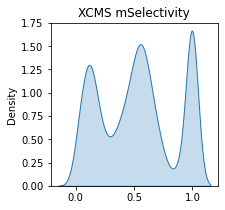

In [133]:
plt.figure(figsize=(3,3))
ax = seaborn.kdeplot(data=xcms_msel,  fill=True,)
plt.title("XCMS mSelectivity")
plt.savefig("kde_XCMS_mSelectivity" + ".png")
plt.savefig("kde_XCMS_mSelectivity" + ".pdf")

In [134]:
# round to 3th decimal
mzlist_mzmine_ = [x['mz'] for x in mzmine_]
print(len(mzlist_mzmine_))
mzlist_mzmine_ = set([str(round(x,3)) for x in mzlist_mzmine_])
mzlist_mzmine_ = sorted([float(x) for x in mzlist_mzmine_])
print(len(mzlist_mzmine_))

mzmine_msel = calculate_selectivity(mzlist_mzmine_)

42099
26447


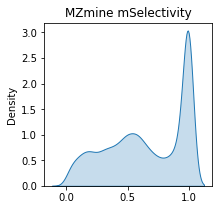

In [135]:
plt.figure(figsize=(3,3))
ax = seaborn.kdeplot(data=mzmine_msel,  fill=True,)
plt.title("MZmine mSelectivity")
plt.savefig("kde_MZmine_mSelectivity" + ".png")
plt.savefig("kde_MZmine_mSelectivity" + ".pdf")

In [144]:
# round to 4th decimal
mzlist_asari_ = [x['mz'] for x in asari_]
print(len(mzlist_asari_))
mzlist_asari_ = set([str(round(x,3)) for x in mzlist_asari_])
mzlist_asari_ = set(mzlist_asari_)
mzlist_asari_ = sorted([float(x) for x in mzlist_asari_])
print(len(mzlist_asari_))

mzasari_msel = calculate_selectivity(mzlist_asari_)

22492
8915


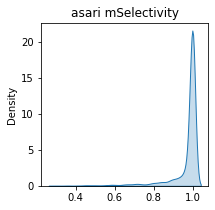

In [145]:
plt.figure(figsize=(3,3))
ax = seaborn.kdeplot(data=mzasari_msel,  fill=True,)
plt.title("asari mSelectivity")
plt.savefig("kde_asari_mSelectivity_noRounding" + ".png")
plt.savefig("kde_asari_mSelectivity_noRounding" + ".pdf")

## Check on other tools

In [23]:
mzmine_L_ = mf.get_featureList('HZV029q_MZmine2.53_LocalMinium_featureTable.csv', start_row=1, mz_col=1, rt_col=2, sep=',')
print(len(mzmine_L_), '\n', mzmine_L_[:3])

24837 
 [{'id': 'row2', 'mz': 80.9884950068959, 'rtime': 4.217872535444738}, {'id': 'row3', 'mz': 80.98846538250262, 'rtime': 4.395459038155128}, {'id': 'row4', 'mz': 80.98851069697628, 'rtime': 4.346391957839508}]


In [24]:
print("mzmine_, mzmine_L_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(mzmine_, mzmine_L_, mz_ppm=5, rt_tolerance=0.1)


mzmine_, mzmine_L_

    ~~~ By best rtime matches ~~~     

Of 42099 list1 features, number of uni-direction matched features is 19675.
Of 24837 list1 features, number of uni-direction matched features is 21386.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 17223


########################################################################
    ~~~ By best m/z matches ~~~     

Of 42099 list1 features, number of uni-direction matched features is 19675.
Of 24837 list1 features, number of uni-direction matched features is 21386.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     17707
########################################################################




In [25]:
print("mzmine_L_, xcms_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(mzmine_L_, xcms_, mz_ppm=5, rt_tolerance=0.1)

mzmine_L_, xcms_

    ~~~ By best rtime matches ~~~     

Of 24837 list1 features, number of uni-direction matched features is 8437.
Of 10901 list1 features, number of uni-direction matched features is 10569.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 6227


########################################################################
    ~~~ By best m/z matches ~~~     

Of 24837 list1 features, number of uni-direction matched features is 8437.
Of 10901 list1 features, number of uni-direction matched features is 10569.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     7072
########################################################################




In [26]:
print("asari_, mzmine_L_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(asari_, mzmine_L_, mz_ppm=5, rt_tolerance=0.1)

asari_, mzmine_L_

    ~~~ By best rtime matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 13734.
Of 24837 list1 features, number of uni-direction matched features is 14987.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 11963


########################################################################
    ~~~ By best m/z matches ~~~     

Of 22440 list1 features, number of uni-direction matched features is 13734.
Of 24837 list1 features, number of uni-direction matched features is 14987.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     11428
########################################################################




**Now MS-DIAL**

In [27]:
msdial_ = mf.get_featureList('HZV029q_MSdial4.90-Area_0_2022824556.txt', start_row=6, mz_col=2, rt_col=1, sep='\t')
print(len(msdial_), msdial_[:3])

54863 [{'id': 'row7', 'mz': 80.0957, 'rtime': 2.476}, {'id': 'row8', 'mz': 80.13656, 'rtime': 3.07}, {'id': 'row9', 'mz': 80.17009, 'rtime': 2.493}]


In [28]:
print("msdial_, mzmine_L_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(msdial_, mzmine_L_, mz_ppm=5, rt_tolerance=0.1)

msdial_, mzmine_L_

    ~~~ By best rtime matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 29113.
Of 24837 list1 features, number of uni-direction matched features is 14354.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 12527


########################################################################
    ~~~ By best m/z matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 29113.
Of 24837 list1 features, number of uni-direction matched features is 14354.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     12143
########################################################################




In [29]:
print("msdial_, mzmine_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(msdial_, mzmine_, mz_ppm=5, rt_tolerance=0.1)

msdial_, mzmine_

    ~~~ By best rtime matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 33581.
Of 42099 list1 features, number of uni-direction matched features is 15823.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 14286


########################################################################
    ~~~ By best m/z matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 33581.
Of 42099 list1 features, number of uni-direction matched features is 15823.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     14298
########################################################################




In [30]:
print("msdial_, asari_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(msdial_, asari_, mz_ppm=5, rt_tolerance=0.1)

msdial_, asari_

    ~~~ By best rtime matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 24651.
Of 22440 list1 features, number of uni-direction matched features is 11448.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 10624


########################################################################
    ~~~ By best m/z matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 24651.
Of 22440 list1 features, number of uni-direction matched features is 11448.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     9537
########################################################################




In [31]:
print("msdial_, xcms_")

valid_matches, dict1, dict2 = mf.bidirectional_best_match(msdial_, xcms_, mz_ppm=5, rt_tolerance=0.1)

msdial_, xcms_

    ~~~ By best rtime matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 14648.
Of 10901 list1 features, number of uni-direction matched features is 8365.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
 5421


########################################################################
    ~~~ By best m/z matches ~~~     

Of 54863 list1 features, number of uni-direction matched features is 14648.
Of 10901 list1 features, number of uni-direction matched features is 8365.
~~~ Biodirectional, unique Number of matched feature pairs: ~~~
     6159
########################################################################




## End

The numbers were used to construct Figure 1A and Suppl Table 1.
